In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

os.system("rm -rf TB")
os.system("mkdir TB")

import sys
sys.path.insert(0, "../Code/")
from train import train_eval

In [2]:
# Define the data generation process

class Logical():

    def __init__(self):
        pass
        
    def gen(self, n):
        return np.random.uniform(size = (n,2))
    
    def gen_bad(self, n):
        X = self.gen(n)
        X_pert = X + np.random.uniform(low = -0.05, high = 0.05, size = X.shape)
        return np.hstack((X,X_pert))
    
    def gen_zeros(self, n):
        X = self.gen(n)
        return np.hstack((X, np.zeros((n,2))))
    
    def gen_random(self, n):
        X = self.gen(n)
        return np.hstack((X, self.gen(n)))
    
    def label(self, X):
        n = X.shape[0]
        y = np.zeros((n,1))
        for i in range(n):
            if X[i, 0] > 0.5 and X[i, 1] > 0.5:
                y[i] = 1.0
        return y

In [3]:
# Define how to evaluate the learned model

def eval(sess, pred, X, n = 500):

        problem = Logical()
    
        # Plot the learned function for dim 0 and 1
        acc = np.zeros((3))
        c = 1
        for mode in ["bad", "random", "zeros"]:
        
            if mode == "bad":
                x = problem.gen_bad(n)
            elif mode == "random":
                x = problem.gen_random(n)
            elif mode == "zeros":
                x = problem.gen_zeros(n)

            y_hat = sess.run(pred, feed_dict = {X: x})

            indices_0 = np.where(y_hat < 0.5)[0]
            indices_1 = np.where(y_hat >= 0.5)[0]

            acc[c - 1] = np.mean(problem.label(x) == np.array(y_hat >= 0.5))

            plt.subplot(3, 1, c)
            plt.scatter(x[indices_0, 0], x[indices_0, 1], marker='x')
            plt.scatter(x[indices_1, 0], x[indices_1, 1], marker='+')
            plt.xlabel("Feature 0")
            plt.ylabel("Feature 1")
            plt.title("Features 2 and 3 drawn using: " + mode)
            
            c += 1
    
        plt.tight_layout()

        plt.savefig("plots.pdf")
        plt.show()

        plt.close()

        # Evaluate whether or not the heuristic was actually enforced on new data
        x = problem.gen_bad(n)
        diffs = np.zeros((6))
        for i in range(x.shape[0]):
            x_cur = x[i, :]
        
            x_pred = sess.run(pred, feed_dict = {X: np.reshape(x_cur, (1,4))})
            
            c = 0
            
            # Evaluate invariance:  MSE of uniform perturbation with range 0.1
            for indices in [[2], [3], [2,3]]:
            
                x_pert = np.copy(x_cur)
                for i in indices:
                    x_pert[i] += np.random.uniform(low = -0.1, high = 0.1)

                x_pred_pert = sess.run(pred, feed_dict = {X: np.reshape(x_pert, (1,4))})

                diffs[c] += (x_pred - x_pred_pert)**2
                c += 1
                
            # Evaluate monotonicity:  Average increase of value after increasing feature by 0.05
            for index in [0, 1, 2]:
                x_pert = np.copy(x_cur)
                x_pert[index] += 0.05
                
                x_pred_pert = sess.run(pred, feed_dict = {X: np.reshape(x_pert, (1,4))})
                
                diffs[c] += x_pred_pert - x_pred
                c += 1
                
        diffs /= n

        out = {}
        out["Model Acc: Bad"] = acc[0]
        out["Model Acc:  Random"] = acc[1]
        out["Model Acc:  Zeros"] = acc[2]
        out["MSE of perturbing Feature 2"] = diffs[0]
        out["MSE of perturbing Feature 3"] = diffs[1]
        out["MSE of perturbing Features 2 and 3"] = diffs[2]
        out["Mean Increase of increasing Feature 0"] = diffs[3]
        out["Mean Increase of increasing Feature 1"] = diffs[4]
        out["Mean Increase of increasing Feature 2"] = diffs[5]
        
        for item in out:
            print(item, ": ", out[item])

In [4]:
# Generate the dataset

problem = Logical()
x = problem.gen_bad(300)
y = problem.label(x)

INFO:tensorflow:Restoring parameters from ./model.cpkt


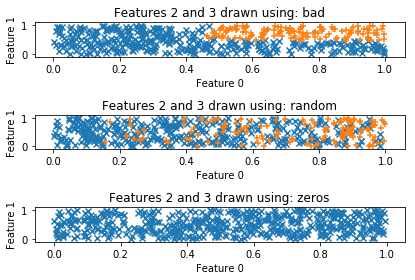

Model Acc: Bad :  0.974
Model Acc:  Random :  0.73
Model Acc:  Zeros :  0.726
MSE of perturbing Feature 2 :  0.35340927124023436
MSE of perturbing Feature 3 :  0.771876220703125
MSE of perturbing Features 2 and 3 :  1.065748291015625
Mean Increase of increasing Feature 0 :  0.585933837890625
Mean Increase of increasing Feature 1 :  0.10294807434082032
Mean Increase of increasing Feature 2 :  0.2650437316894531


In [5]:
# Train a normal model

train_eval(x, y, "binary_classification", eval_func = eval)

INFO:tensorflow:Restoring parameters from ./model.cpkt


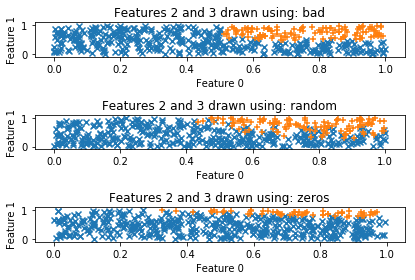

Model Acc: Bad :  0.99
Model Acc:  Random :  0.916
Model Acc:  Zeros :  0.826
MSE of perturbing Feature 2 :  1.30201515275985e-06
MSE of perturbing Feature 3 :  0.4311947021484375
MSE of perturbing Features 2 and 3 :  0.42198095703125
Mean Increase of increasing Feature 0 :  1.329618408203125
Mean Increase of increasing Feature 1 :  0.6731476440429688
Mean Increase of increasing Feature 2 :  -0.0008734608888626099
INFO:tensorflow:Restoring parameters from ./model.cpkt


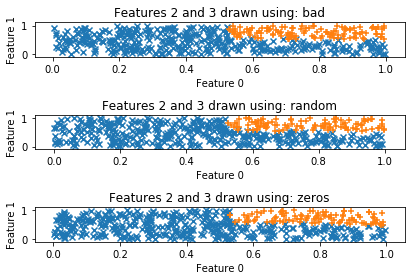

Model Acc: Bad :  0.978
Model Acc:  Random :  0.964
Model Acc:  Zeros :  0.954
MSE of perturbing Feature 2 :  7.486222311854362e-07
MSE of perturbing Feature 3 :  1.4778979821130634e-06
MSE of perturbing Features 2 and 3 :  2.404083730652928e-06
Mean Increase of increasing Feature 0 :  0.5161997680664062
Mean Increase of increasing Feature 1 :  0.4714267883300781
Mean Increase of increasing Feature 2 :  -0.0006053393483161926


In [6]:
# Show the effects of discouraging the use of one or both of the 'bad' features

train_eval(x, y, "binary_classification", eval_func = eval, heuristics = [["inv", 2, 0.1, 1000.0]])
train_eval(x, y, "binary_classification", eval_func = eval, heuristics = [["inv", 2, 0.1, 1000.0], ["inv", 3, 0.1, 1000.0]])
